In [ ]:
%matplotlib inline

### Plotting functions and useful imports

In [ ]:
# Python 2/3 compatibility
from __future__ import print_function, division

import itertools
import time


import numpy as np
import matplotlib.pyplot as plt

# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44], [255, 0, 0]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))



def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    :param cm: (numpy matrix) confusion matrix
    :param classes: [str]
    :param normalize: (bool)
    :param title: (str)
    :param cmap: (matplotlib color map)
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    plt.figure(figsize=(8, 8))   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### PyTorch and GPU (CUDA support)

We will use the CIFAR10 dataset.
There are 10 classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.


![CIFAR10](http://pytorch.org/tutorials/_images/cifar10.png)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

if th.cuda.is_available():
  # Make CuDNN Determinist
  th.backends.cudnn.deterministic = True
  th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")


In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 40000 # Max: 50 000 - n_val_samples
n_val_samples = 10000


train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
#test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))  # we can use it to test on a subset
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1]



In [ ]:
num_workers = 5
test_batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Let us show some of the training images, for fun.




     horse        cat        cat      horse


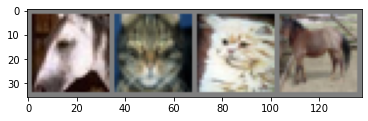

In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('{:>10}'.format(classes[labels[j]]) for j in range(test_batch_size)))

In [ ]:
# Useful imports
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0.003)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.003)
    return criterion, optimizer

In [ ]:
def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)

# Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler,
                                          num_workers=num_workers)

In [ ]:
def train(net, batch_size, n_epochs, learning_rate, must_print=True):
    """
    Train a neural network and print statistics of the training
    
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    :param must_print: (bool) if true, print statement
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):

            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0 and must_print:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with th.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            th.save(net.state_dict(), best_model_path)
        if must_print:
          print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    if must_print:
      print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(th.load(best_model_path))
    
    return train_history, val_history

In [ ]:
def dataset_accuracy(net, data_loader, name=""):
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1) #_ max value, predicted return index of max value for each line
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * float(correct) / total
    print('Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))
    return accuracy

def train_set_accuracy(net):
    dataset_accuracy(net, train_loader, "train")

def val_set_accuracy(net):
    dataset_accuracy(net, val_loader, "validation")  
    
def test_set_accuracy(net):
    return dataset_accuracy(net, test_loader, "test")

def compute_accuracy(net):
    train_set_accuracy(net)
    val_set_accuracy(net)
    acc = test_set_accuracy(net)
    return acc
    
print("Computing accuracy...")

Computing accuracy...


In [ ]:
def accuracy_per_class(net):
    net = net.to(device)
    n_classes = 10
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(test_batch_size):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    return confusion_matrix

confusion_matrix = accuracy_per_class(net)

Class      Accuracy (%)
plane        73.70   
car          75.40   
bird         49.50   
cat          34.10   
deer         60.80   
dog          63.50   
frog         76.20   
horse        67.50   
ship         65.30   
truck        77.60   


### Confusion Matrix

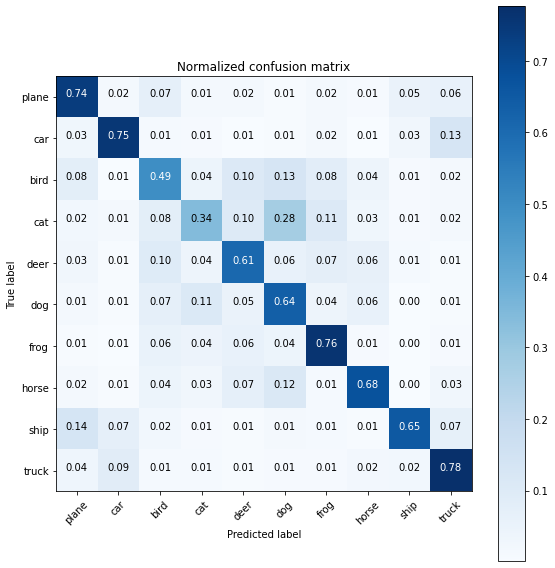

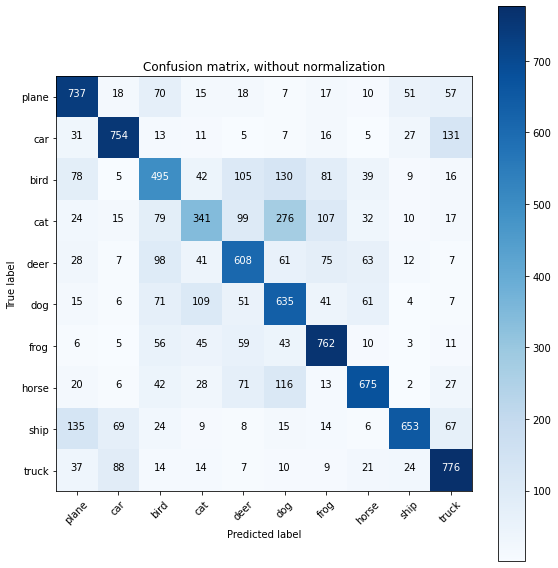

In [ ]:
# Plot normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes, normalize=True,
                      title='Normalized confusion matrix')

# Plot non-normalized confusion matrix
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')

In [ ]:
class MyConvolutionalNetwork(nn.Module):
    def __init__(self):
        super(MyConvolutionalNetwork, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 18, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
 
        #### START CODE: ADD NEW LAYERS ####
        # (do not forget to update `flattened_size`:
        # the input size of the first fully connected layer self.fc1)

        self.conv2 = nn.Conv2d(18, 64, kernel_size = 3, stride = 1, padding=1)      
        self.conv2bis = nn.Conv2d(64, 64, kernel_size = 3, stride = 1, padding=1) 
 
        self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding=1)     
        self.conv3bis = nn.Conv2d(128, 128, kernel_size = 3, stride = 1, padding=1)

        torch.nn.init.kaiming_uniform_(self.conv3.weight)
        torch.nn.init.kaiming_uniform_(self.conv3bis.weight)
        torch.nn.init.kaiming_uniform_(self.conv2.weight)
        torch.nn.init.kaiming_uniform_(self.conv2bis.weight)
        torch.nn.init.kaiming_uniform_(self.conv1.weight)
        
        # Size of the output of the last convolution:
        self.flattened_size = 128 * 4 * 4
        ### END CODE ###
        
        self.fc1 = nn.Linear(self.flattened_size, 64)
        self.fc2 = nn.Linear(64, 10)
 
    def forward(self, x):
        """
        Forward pass,
        x shape is (batch_size, 3, 32, 32)
        (color channel first)
        in the comments, we omit the batch_size in the shape
        """
        # shape : 3x32x32 -> 18x32x32
        x = F.relu(self.conv1(x))
        # 18x32x32 -> 18x16x16
        x = self.pool(x)      
        
        #### START CODE: USE YOUR NEW LAYERS HERE ####

        x = F.relu(self.conv2(x))
        x = F.relu(self.conv2bis(x))
        x = self.pool(x) 
        
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv3bis(x))
        x = self.pool(x)        

        #### END CODE ####
        
        # Check the output size
        output_size = np.prod(x.size()[1:])
        assert output_size == self.flattened_size,\
                "self.flattened_size is invalid {} != {}".format(output_size, self.flattened_size)
        
         # 18x16x16 -> 4608
        x = x.view(-1, self.flattened_size)
        # 4608 -> 64
        x = F.relu(self.fc1(x))
        # 64 -> 10
        # The softmax non-linearity is applied later (cf createLossAndOptimizer() fn)
        x = self.fc2(x)
        return x

In [ ]:
best_net = MyConvolutionalNetwork()
train_history, val_history = train(best_net, batch_size=64, n_epochs=30, learning_rate=0.001, must_print=True)
compute_accuracy(best_net)

===== HYPERPARAMETERS =====
batch_size= 64
n_epochs= 30
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 2.16 took: 1.30s
Epoch 1, 20% 	 train_loss: 1.87 took: 1.02s
Epoch 1, 30% 	 train_loss: 1.70 took: 1.05s
Epoch 1, 40% 	 train_loss: 1.61 took: 1.02s
Epoch 1, 50% 	 train_loss: 1.55 took: 1.02s
Epoch 1, 60% 	 train_loss: 1.49 took: 1.11s
Epoch 1, 70% 	 train_loss: 1.43 took: 1.04s
Epoch 1, 80% 	 train_loss: 1.38 took: 1.23s
Epoch 1, 90% 	 train_loss: 1.37 took: 1.07s
Validation loss = 1.30
Epoch 2, 10% 	 train_loss: 1.28 took: 1.35s
Epoch 2, 20% 	 train_loss: 1.26 took: 1.03s
Epoch 2, 30% 	 train_loss: 1.22 took: 1.23s
Epoch 2, 40% 	 train_loss: 1.21 took: 1.08s
Epoch 2, 50% 	 train_loss: 1.23 took: 1.07s
Epoch 2, 60% 	 train_loss: 1.18 took: 1.03s
Epoch 2, 70% 	 train_loss: 1.16 took: 1.04s
Epoch 2, 80% 	 train_loss: 1.15 took: 1.02s
Epoch 2, 90% 	 train_loss: 1.14 took: 1.00s
Validation loss = 1.10
Epoch 3, 10% 	 train_loss: 1.04 took: 1.27s
Epoch 3, 20% 	 train_loss: 1.05 took: 1.1

76.73

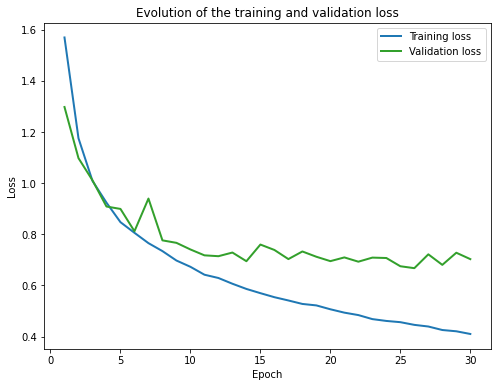

In [ ]:
plot_losses(train_history, val_history)

In [ ]:
print("Computing accuracy...")
confusion_matrix = accuracy_per_class(best_net)

Computing accuracy...
Class      Accuracy (%)
plane        86.80   
car          83.60   
bird         67.10   
cat          58.20   
deer         72.50   
dog          71.80   
frog         80.40   
horse        81.00   
ship         80.90   
truck        85.00   


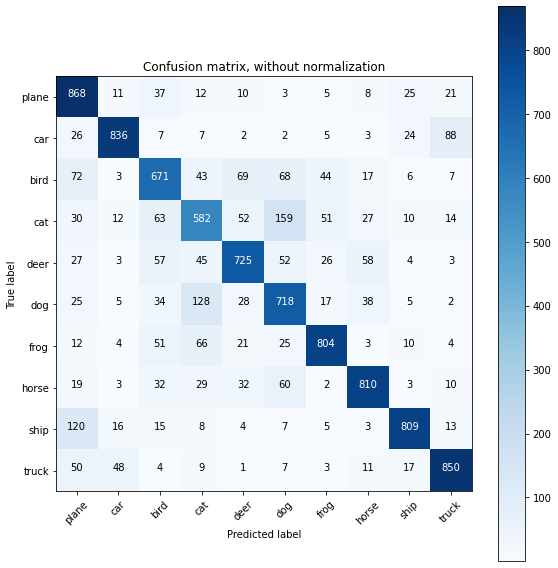

In [ ]:
plot_confusion_matrix(confusion_matrix, classes,
                      title='Confusion matrix, without normalization')